In [147]:
import re
import urllib.request
from bs4 import BeautifulSoup
from pandas import DataFrame
import pandas as pd
import datetime

# page nos. 1 to 1539
persian_steingass_url = 'https://dsal.uchicago.edu/cgi-bin/app/steingass_query.py?page={}'

In [164]:
def getSteingassPage(page):
    with urllib.request.urlopen(persian_steingass_url.format(page)) as response:
        html = response.read()
        html = html.decode('utf-8')
    bs = BeautifulSoup(html)
    df = DataFrame([{
            'def': re.sub(r'^\s*,', '', ' '.join(sib.text.strip() 
                for sib in hw.next_siblings)).strip(),
            'pa': hw.pa.string,
            'ro': hw.i.string if hw.i else None,
            'lang': hw.parent.lang.string if hw.parent.lang else None,
            'page': page
            } for hw in bs.find_all('hw')])
    if len(df) == 0:
        return df
    else:
        return df[['pa', 'ro', 'def', 'lang', 'page']]

In [167]:
pages = []

for page in range(1, 1540):
    print('=', end='')
    if page % 5 == 0:
        print('|', end='')
        if page % 50 == 0:
            print(page, datetime.datetime.now())
    pages.append(getSteingassPage(page))

pd.concat(pages)

=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|50 2022-02-01 16:26:58.036586
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|100 2022-02-01 16:27:21.014403
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|150 2022-02-01 16:27:43.881089
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|200 2022-02-01 16:28:06.828299
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|250 2022-02-01 16:28:29.706483
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|300 2022-02-01 16:28:52.504979
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|350 2022-02-01 16:29:15.890356
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|400 2022-02-01 16:29:38.687039
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|450 2022-02-01 16:30:01.519369
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|500 2022-02-01 16:30:24.174948
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|550 2022-02-01 16:30:46.884391


,pa,ro,def,lang,page
0,ا,alif,the first letter of the Arabic and Persian alp...,None,1
1,آ,ā,(S. ā ) Preposition inseparably joined to verb...,None,1
0,آب,āb,"(S. ap ) Water; river; largesse, gift, price; ...",None,3
1,آب,āb,"(in Zand and Pāzand), Father.",None,3
2,آب,āb,The Syro-Macedonian month of August.,A,3
...,...,...,...,...,...
11,ی‍ﮩ‍ی‍ﮩ‍ة,"yahyahat, yahyahah",Calling to camels yāh yāh.,A,1539
12,یئس,yaʼis,"Despondent, despairing.",A,1539
13,ییعث,yaiʻus̤,A district of moving sands in Arabia Felix dan...,A,1539
14,ییلا,yailā,Summer-quarters.,T,1539


In [168]:
FullDict = pd.concat(pages)
FullDict

,pa,ro,def,lang,page
0,ا,alif,the first letter of the Arabic and Persian alp...,None,1
1,آ,ā,(S. ā ) Preposition inseparably joined to verb...,None,1
0,آب,āb,"(S. ap ) Water; river; largesse, gift, price; ...",None,3
1,آب,āb,"(in Zand and Pāzand), Father.",None,3
2,آب,āb,The Syro-Macedonian month of August.,A,3
...,...,...,...,...,...
11,ی‍ﮩ‍ی‍ﮩ‍ة,"yahyahat, yahyahah",Calling to camels yāh yāh.,A,1539
12,یئس,yaʼis,"Despondent, despairing.",A,1539
13,ییعث,yaiʻus̤,A district of moving sands in Arabia Felix dan...,A,1539
14,ییلا,yailā,Summer-quarters.,T,1539


In [170]:
FullDict.to_csv('steingass.csv')

In [171]:
FullDictCsv = pd.read_csv('steingass.csv')

<AxesSubplot:>

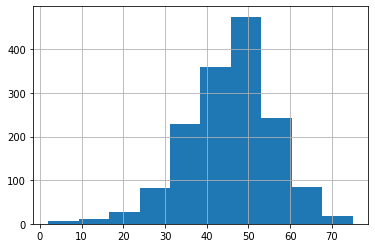

In [176]:
FullDictCsv.page.value_counts().hist()

In [186]:
for p in range(1, 1540):
    if not p in list(FullDictCsv.page):
        print(p)

2
41
486
520
665
666


In [203]:
FullDict['def'].str.len().describe()

count    69888.000000
mean        78.843736
std        185.666336
min          0.000000
25%         22.000000
50%         39.000000
75%         82.000000
max      17483.000000
Name: def, dtype: float64

In [202]:
FullDictCsv[FullDictCsv['def'].str.len() < 10]

,Unnamed: 0,pa,ro,def,lang,page
29,6,اباش,ubāsh,"Mob, &c.",NaN,4
83,9,آبجر,āb-jar,Ebb-tide.,NaN,5
90,16,ابحار,abḥār,Seas.,A,5
127,12,آبدست جاى,ābdast-jāy,A privy.,NaN,6
135,20,ابدية,abadīyat,Eternity.,A,6
...,...,...,...,...,...,...
69807,45,يوع,yūḥ,The sun.,A,1537
69811,49,يوده,yoda,A unit.,NaN,1537
69863,33,يونيوس,yūniyūs,June.,NaN,1538
69871,41,ي‍ﮩ‍ره,yuhra,Desirous.,NaN,1538


In [165]:
getSteingassPage(24)

,pa,ro,def,lang,page
0,اخترام,iḵẖtirām,"Tearing; destroying, extirpating; cutting off,...",A,24
1,اخترسپاه,aḵẖtar-sipāh,A sovereign whose army is numerous as the stars.,None,24
2,اخترستان,aḵẖtaristān,Name of a treatise on astronomy.,None,24
3,اختر شمار,aḵẖtar-shumār,An astronomer.,None,24
4,اختر ضمير,aḵẖtar-ẓamīr,Of an enlightened mind; of a bright intellect.,a,24
5,اختر گراى,aḵẖtar-girāy,"Who examines the stars, investigates their cou...",None,24
6,اخترگو,aḵẖtar-go (gū),"An astrologer, augur.",None,24
7,اخترى,aḵẖtarī,"A diviner, soothsayer.",None,24
8,اختزاع,iḵẖtizāʻ,"Tearing away, alienating (one) from his kindred.",A,24
9,اختزال,iḵẖtizāl,"Tearing away, alienating from kindred; being a...",A,24


In [156]:
with urllib.request.urlopen(persian_steingass_url.format(24)) as response:
    html = response.read()
    html = html.decode('utf-8')
    bs = BeautifulSoup(html)

In [159]:
[{
    'def': [sib.text for sib in hw.next_siblings],
    'pa': hw.pa.string,
    'ro': hw.i.string if hw.i else None,
    'lang': hw.parent.lang.string if hw.parent.lang else None
    } for hw in bs.find_all('hw')]

[{'def': [' , Tearing; destroying, extirpating; cutting off, carrying off. \n\t\t\t'],
  'pa': 'اخترام',
  'ro': 'iḵẖtirām',
  'lang': 'A'},
 {'def': [' , A sovereign whose army is numerous as the stars. \n\t\t\t'],
  'pa': 'اخترسپاه',
  'ro': 'aḵẖtar-sipāh',
  'lang': None},
 {'def': [' , Name of a treatise on astronomy. \n\t\t\t'],
  'pa': 'اخترستان',
  'ro': 'aḵẖtaristān',
  'lang': None},
 {'def': [' , An astronomer. \n\t\t\t'],
  'pa': 'اختر شمار',
  'ro': 'aḵẖtar-shumār',
  'lang': None},
 {'def': [' , Of an enlightened mind; of a bright intellect. \n\t\t\t'],
  'pa': 'اختر ضمير',
  'ro': 'aḵẖtar-ẓamīr',
  'lang': 'a'},
 {'def': [' , Who examines the stars, investigates their course, astrologer. \n\t\t\t'],
  'pa': 'اختر گراى',
  'ro': 'aḵẖtar-girāy',
  'lang': None},
 {'def': [' , An astrologer, augur. \n\t\t\t'],
  'pa': 'اخترگو',
  'ro': 'aḵẖtar-go (gū)',
  'lang': None},
 {'def': [' , A diviner, soothsayer. \n\t\t\t'],
  'pa': 'اخترى',
  'ro': 'aḵẖtarī',
  'lang': None},
 {'d